## **Ensayo** - SVM

In [1]:
import numpy as np
from sklearn import datasets
import tensorflow as tf 
import matplotlib.pyplot as plt

In [2]:
if tf.__version__.startswith("2."):
    import tensorflow.compat.v1 as tf
    tf.compat.v1.disable_v2_behavior()
    tf.compat.v1.disable_eager_execution()

Instructions for updating:
non-resource variables are not supported in the long term


### Support Vector Machine

Es un algoritmo de aprendizaje supervisado, su objetivo es encontrar un hiperplano en un espacio N-dimensional, las dimensiones van a estar dadas por el número de caracteristícas que se posean. Prácticamente el hiperplano es un límite de decisión que permiten clasificar los datos.

Este algoritmo es muy potente y versátil, capaz de realizar clasificación lineal, no lineal, por regresión e incluso detección de anomalías. El modelo fue creado como clasificaciión binaria pero ha ido teniendo variaciones como clasificación múltiple y regresión. SVM como se mencionó anteriormente se base en el concepto de hiper-plano, com se puede ver en la **Imagen 1** existe una línea recta que divide el plano en dos áreas específicas, lo que se busca en realidad es determinar que si la hipotesis es positiva prediga que el elemento pertenece a la clase 1 y si es negativa pertenece a la clase 0.

<center><b>Imagen 1</b>. Representación del algoritmo de SVM</center>

<img src="https://raw.githubusercontent.com/estuardozapeta/Statistical-Learning-I-Tarea-6/master/svm.jpg">

Fuente: https://www.youtube.com/watch?v=kUkuwyiCAAs&feature=youtu.be

#### Hipótesis y Función de costo

Dado un conjunto de observaciones separables de ejemplos:
$D = {(x_1, y_1)\dotsi(x_n, y_n)}$, donde $xi \in R^d$ e $yi \in {+1, -1}$ se puede definir un hiperplano de separación con una función lineal que es capaz de separar dicho conjunto:

$$ f(x) = (w_ix_i,  +\dotsi+  w_dx_d) + b = w^T x + b$$

donde $w_i \in R$  $\forall_i = 1  , d$ y $b \in R$.
Y su hiperplano óptimo:

$$H : w^T x + b = 0$$

Siendo $b$ una constante que indica la posición del hiperplano respecto al origen de coordenadas. Esta constante recibe el nombre de sesgo y $w$ es el vector normal del hiperplano.

Dicho hiperplano debe cumplir las siguientes desigualdades:

$$(w^T x_i) + b > 0 \quad\text{si}\quad\text y_i = +1 \forall_i = 1 ,\dotsi, n$$
$$(w^T x_i) + b < 0 \quad\text{si}\quad\text y_i = -1 \forall_i = 1 ,\dotsi, n$$

Es decir, si el resultado de la operación es positivo la muestra permanecerá a una clase, caso contrario la otra clase. Ahora se considera un hiperplano con margen máximo.

$$(w^T x_i) + b \geq 1 \quad\text{si}\quad\text y_i = +1$$
$$(w^T x_i) + b \geq -1 \quad\text{si}\quad\text y_i = -1$$

Las expresiones anteriores se puede escribir de forma compacta:

$$y_i((w^T x_i) + b) \geq 1 \forall_i = 1 , \dotsi , n$$

En un problema que es linealmente separable habrá infinitos hiperplanos que cumplan esta condición. Lo que se busca es aquel que tenga un mayor margen. Es decir, se desea maximizar la distancia entre los datos y la frontera de decisión. Los puntos que caen sobre cada uno de los hiperplanos son los que cumplen:

$$H_1 : (w^T x_i) + b = +1$$
$$H_2 : (w^T x_i) + b = -1$$

Por lo tanto, estos hiperplanos son paralelos al hiperplano $H$ con la ecuación: $H : w^T x + b = 0$. Si a esto se le imponen las condiciones mencionadas anteriormente se puede escribir de forma equivalente como un problema de programación cuadrática y sería de la siguiente forma:

$$\frac{1}{2} ||w||^2$$

Esta formulación  muestra que su función objetivo es la minimización de una norma con respecto a un vector de pesos normales de hiperplano sujeto a restricciones lineales:

$$ J(\theta) = \frac{1}{2m}\sum_{i=1}^m(h_\theta(x^{(i)}) - y^{(i)})^2 $$

Fuente: https://www.youtube.com/watch?v=geI6lM5iOl0&feature=youtu.be

### Ejemplo usando TensorFlow

#### Carga de datos

In [3]:
iris = datasets.load_iris()

#### Selección de "**x**" y "**y**"

In [15]:
x = iris["data"][:, (2, 3)]
y = (iris["target"] == 0).astype(np.float64)

#### Función de entreno

In [49]:
def train_svm(x_train, y_train, lr, c, epochs):
    t_train = np.array([1.0 if z == 1 else -1.0 for z in y_train])

    tf.reset_default_graph()
    g = tf.Graph()
    
    with g.as_default():
        
        x = tf.placeholder(tf.float32, shape = (150, 2))
        y = tf.placeholder(tf.float32, shape = (150, 1))
        t = tf.placeholder(tf.float32, shape = (150, 1))

        lr_ = tf.placeholder(tf.float32)
        c_ = tf.placeholder(tf.float32)        
        
        w = tf.Variable(tf.truncated_normal(shape = (2, 1)))
        b = tf.Variable(tf.truncated_normal(shape = (1, 1)))
        
        svm_op = tf.add(tf.matmul(x, w), b)
        t_hat = tf.sign(svm_op)
        w_norm = tf.multiply(tf.constant(0.5), tf.reduce_sum(tf.square(w)))
        classif_term = tf.reduce_sum(tf.maximum(tf.constant(0.), tf.subtract(tf.constant(1.), tf.multiply(t, svm_op))))
        cost = tf.add(w_norm, tf.multiply(c_, classif_term))
        accuracy = tf.reduce_mean(tf.cast(tf.equal(t_hat, t), tf.float32))
        trainstep = tf.train.GradientDescentOptimizer(lr_).minimize(cost) 
        
        init = tf.global_variables_initializer()        
   
    with tf.Session(graph = g) as session:
        
        session.run(init)       
        for epoch in range(epochs):            
            _, cst, acc = session.run([trainstep, cost, accuracy], 
                                  feed_dict = {x : x_train, y : y_train.reshape((150, 1)), t : t_train.reshape((150, 1)), lr_ : lr, c_ : c})
        w_, b_ = session.run([w, b])        
    
    return w_, b_

#### Función para graficar el hiper-plano

In [50]:
def graph_svm(x, y, w, b): 
    plt.scatter(x[y == 1, 0], x[y == 1, 1], c = 'g', marker = 'o', label="setosa")
    plt.scatter(x[y == 0, 0], x[y == 0, 1], c = 'y', marker = '*', label="otras")
    plt.legend()
    plt.title("Iris setosa")
    grillaX = np.array([d[0] for d in x])
    m_ = -w[0,0] / w[1,0]
    b_ = -b[0] / w[1,0]
    yDesBound = b_ + m_*grillaX
    plt.plot(grillaX, yDesBound, 'k-', label = "Límite de decisión")

#### Prueba con lr = 0.001, c = 5, epochs = 200

In [51]:
w, b = train_svm(x, y, 0.001, 5, 200)

#### Hiper-plano

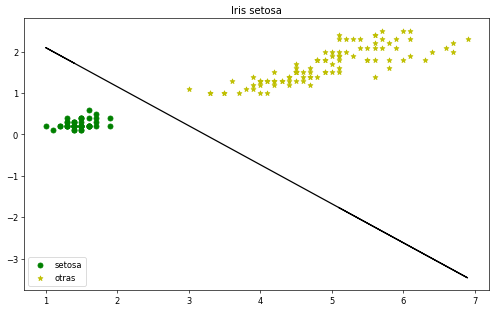

In [52]:
fig = plt.figure(figsize=(10, 6), dpi= 60, facecolor='w', edgecolor='k')
graph_svm(x, y, w, b)

#### Funciones Kernel

Un kernel es una función que devuelve el resultado del producto punto entre dos vectores en un espacio dimensional diferente al espacio original en el que se encuentran los vectores. 

Para entrar en detalle, tomando de base las fórmulas matemáticas que se emplean para resolver problemas de optimización, hay que recordar que resuelven usando un producto punto, si este se sustituye por un kernel, se obtienen prácticamente los vectores soporte (y el hiperplano) en la dimensión correspondiente al kernel. Ha esto se le suele conocer como kernel trick, porque, con solo una pequeña modificación del problema original, se puede lograr el resultado para cualquier dimensión y esto gracias a los kernels. Existen distintos kernels, algunos de los más utilizados son:
 
- **Kernel lineal**. Si se emplea un Kernel lineal, el SVM obtenido es equivalente al Support Vector Classifier.
- **Kernel polinómico**. Cuando se emplea d=1 y c=0, el resultado es el mismo que el de un kernel lineal. Si d>1, se generan límites de decisión no lineales, aumentando la no linealidad a medida que aumenta d. No suele ser recomendable emplear valores de d mayores 5 por problemas de overfitting.

Fuente: https://www.youtube.com/watch?v=01hse_MOx0g&feature=youtu.be

#### Algunos comentarios en relación a otros modelos

SVM  se ve afectado por su capacidad predictiva por el sobreentrenamiento a unos datos con ruido, lo cual se refleja en un bajo rendimiento ante datos nuevos, es decir, aquellos que no se utilizaron para generar el modelo. Para el caso de los modelos de clasificación como árbol de decisión, el rendimiento es mucho mejor, quizás por la manera de predicción local.